# Transfer Learning Tutorial

http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import numpy as np
import matplotlib.pyplot as plt
import time
import os

## 1. Load Data

Using `torchvision` and `torch.utils.data` for data loading. Training a model to classify ants and bees; 120 training images each cat. 75 val images each. [data link](https://download.pytorch.org/tutorial/hymenoptera_data.zip)

In [8]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomSizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Scale(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
               for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:397: UserWarning: The use of the transforms.RandomSizedCrop transform is deprecated, please use transforms.RandomResizedCrop instead.
/Users/WayNoxchi/Miniconda3/envs/fastai/lib/python3.6/site-packages/torchvision-0.2.0-py3.6.egg/torchvision/transforms/transforms.py:156: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [18]:
torchvision.transforms.Scale??

```
Init signature: torchvision.transforms.Scale(*args, **kwargs)
Source:        
class Scale(Resize):
    """
    Note: This transform is deprecated in favor of Resize.
    """
    def __init__(self, *args, **kwargs):
        warnings.warn("The use of the transforms.Scale transform is deprecated, " +
                      "please use transforms.Resize instead.")
        super(Scale, self).__init__(*args, **kwargs)
```

In [17]:
torchvision.transforms.Resize??

```
Init signature: torchvision.transforms.Resize(size, interpolation=2)
Source:        
class Resize(object):
    """Resize the input PIL Image to the given size.

    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (h, w), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
```

## 2. Visualize a few images

In [19]:
plt.pause?

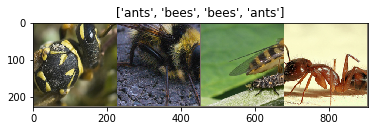

In [21]:
def imshow(inp, title=None):
    """Imshow for Tensor"""
    inp = inp.numpy().transpose((1,2,0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updates

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Huh, cool

## 3. Training the model

* Scheduling the learning rate
* Saving the best model

Parameter `scheduler` is an LR scheduler object from `torch.optim.lr_scheduler`

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    
    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True) # Set model to training mode
            else:
                model.train(False) # Set model to evaulation mode
            
            running_loss = 0.0
            running_corrects = 0
            
            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data
                
                # wrap them in Variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)
                
                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                
                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
                
                # statistics
                running_loss += loss.data[0]
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # deep copy the model     ### <-- ooo this is very cool. .state_dict() & acc
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                mest_model_wts = model.state_dict()
        
        print()

    time_elapsed = time.time() - since
    print('Training complete in {time_ellapsed//60:.0f}m {time_elapsed%60:.0fs}')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## 4. Visualizing the model's predictions

In [26]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()
    
    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title(f'predicted: {class_names[preds[j]]}')
            imshow(inputs.cpu().data[j])
            
            if images_so_far == num_images:
                return

```
Variable.cpu(self)

Source:   
    def cpu(self):
        return self.type(getattr(torch, type(self.data).__name__))
```

In [25]:
# looking at the cpu() method
temp = Variable(torch.FloatTensor([1,2]))
temp.cpu()

Variable containing:
 1
 2
[torch.FloatTensor of size 2]

## 5. Finetuning the ConvNet

Load a pretrained model and reset final fully-connected layer

In [32]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Delay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

```
torch.optim.lr_scheduler.StepLR

--> defines `get_lr(self):

def get_lr(self):
    return [base_lr * self.gamma ** (self.last_epoch // self.step_size)
                    for base_lr in self.base_lrs]
```

so `gamma` is exponentiated by ( last_epoch // step_size )

## 5.1 Train and Evaluate

Should take 15-25 min on CPU; < 1 min on GPU.

In [33]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1495 Acc: 0.6967
val Loss: 0.0914 Acc: 0.8562

Epoch 1/24
----------
train Loss: 0.1819 Acc: 0.7049
val Loss: 0.1310 Acc: 0.8301

Epoch 2/24
----------
train Loss: 0.1345 Acc: 0.8197
val Loss: 0.1360 Acc: 0.8366

Epoch 3/24
----------
train Loss: 0.1504 Acc: 0.8074
val Loss: 0.1023 Acc: 0.8758

Epoch 4/24
----------
train Loss: 0.1504 Acc: 0.7541
val Loss: 0.0789 Acc: 0.8693

Epoch 5/24
----------
train Loss: 0.1248 Acc: 0.8238
val Loss: 0.0900 Acc: 0.8758

Epoch 6/24
----------
train Loss: 0.1047 Acc: 0.7992
val Loss: 0.0956 Acc: 0.8562

Epoch 7/24
----------
train Loss: 0.0680 Acc: 0.8893
val Loss: 0.0596 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.0729 Acc: 0.8770
val Loss: 0.0555 Acc: 0.9085

Epoch 9/24
----------
train Loss: 0.0786 Acc: 0.8607
val Loss: 0.0482 Acc: 0.9281

Epoch 10/24
----------
train Loss: 0.0975 Acc: 0.8279
val Loss: 0.0516 Acc: 0.9281

Epoch 11/24
----------
train Loss: 0.0527 Acc: 0.9180
val Loss: 0.0509 Acc: 0.9281

Ep

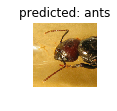

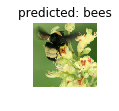

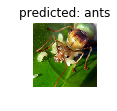

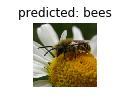

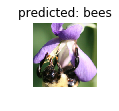

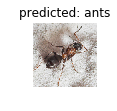

In [34]:
visualize_model(model_ft)

## 6. ConvNet as a fixed feature extractor

Freeze entire network except final layer. Need set `requires_grad == False` to freeze pars st grads aren't computed in `backward()`.

[Link to Documentation](http://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward)

In [35]:
model_conv = torchvision.models.resnet18(pretrained=True)
for par in model_conv.parameters():
    par.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
    model_conv = model_conv.cuda()
    
criterion = nn.CrossEntropyLoss()

# Observe that only parameters of the final layer are being optimized as 
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Delay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

## 6.1 Train and evaluate

For CPU: will take about half the time as before. This is expected as grads don't need to be computed for most of the network -- the forward pass though, has to be computed.

In [36]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.1503 Acc: 0.6885
val Loss: 0.0609 Acc: 0.9085

Epoch 1/24
----------
train Loss: 0.1271 Acc: 0.7746
val Loss: 0.0814 Acc: 0.8497

Epoch 2/24
----------
train Loss: 0.1033 Acc: 0.8115
val Loss: 0.0569 Acc: 0.9150

Epoch 3/24
----------
train Loss: 0.1474 Acc: 0.7500
val Loss: 0.0440 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.1489 Acc: 0.7254
val Loss: 0.1234 Acc: 0.8039

Epoch 5/24
----------
train Loss: 0.1206 Acc: 0.8197
val Loss: 0.0673 Acc: 0.9085

Epoch 6/24
----------
train Loss: 0.1041 Acc: 0.8484
val Loss: 0.0473 Acc: 0.9477

Epoch 7/24
----------
train Loss: 0.0945 Acc: 0.8484
val Loss: 0.0549 Acc: 0.9412

Epoch 8/24
----------
train Loss: 0.0659 Acc: 0.8730
val Loss: 0.0607 Acc: 0.9216

Epoch 9/24
----------
train Loss: 0.0691 Acc: 0.8893
val Loss: 0.0474 Acc: 0.9477

Epoch 10/24
----------
train Loss: 0.0921 Acc: 0.8279
val Loss: 0.0494 Acc: 0.9412

Epoch 11/24
----------
train Loss: 0.0918 Acc: 0.8402
val Loss: 0.0443 Acc: 0.9412

Ep

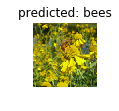

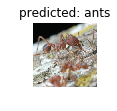

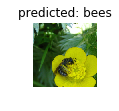

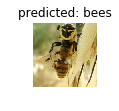

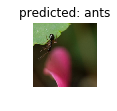

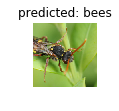

In [38]:
visualize_model(model_conv)

plt.ioff()
plt.show()